In [1]:
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import seaborn as sns

In [2]:
texts1 = "Word2vec is a technique for natural language processing (NLP) published in 2013. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that they capture the semantic and syntactic qualities of words; as such, a simple mathematical function (cosine similarity) can indicate the level of semantic similarity between the words represented by those vectors. Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word2vec can utilize either of two model architectures to produce these distributed representations of words: continuously sliding bag-of-words (CBOW) or continuously sliding skip-gram. In both architectures, word2vec considers both individual words and a sliding context window as it iterates over the corpus. The CBOW can be viewed as a ‘fill in the blank’ task, where the word embedding represents the way the word influences the relative probabilities of other words in the context window. Words which are semantically similar should influence these probabilities in similar ways, because semantically similar words should be used in similar contexts. The order of context words does not influence prediction (bag-of-words assumption). In the continuous skip-gram architecture, the model uses the current word to predict the surrounding window of context words.[1][2] The skip-gram architecture weighs nearby context words more heavily than more distant context words. According to the authors' note,[3] CBOW is faster while skip-gram does a better job for infrequent words. After the model has trained, the learned word embeddings are positioned in the vector space such that words that share common contexts in the corpus — that is, words that are semantically and syntactically similar — are located close to one another in the space.[1] More dissimilar words are located farther from one another in the space"

In [3]:
texts2 = 'GloVe, coined from Global Vectors, is a model for distributed word representation. The model is an unsupervised learning algorithm for obtaining vector representations for words. This is achieved by mapping words into a meaningful space where the distance between words is related to semantic similarity.[1] Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. It is developed as an open-source project at Stanford[2] and was launched in 2014. As log-bilinear regression model for unsupervised learning of word representations, it combines the features of two model families, namely the global matrix factorization and local context window methods.[3] GloVe can be used to find relations between words like synonyms, company-product relations, zip codes and cities, etc. However, the unsupervised learning algorithm is not effective in identifying homographs, that is, words with the same spelling and different meanings. This is as the unsupervised learning algorithm calculates a single set of vectors for words with the same morphological structure.[4] The algorithm is also used by the SpaCy library to build semantic word embedding features, while computing the top list words that match with distance measures such as cosine similarity and Euclidean distance approach.[5] GloVe was also used as the word representation framework for the online and offline systems designed to detect psychological distress in patient interviews'

In [4]:
texts1 = texts1.split('.')
texts2 = texts2.split('.')

In [5]:
f'len of text1: {len(texts1)}, len of text2: {len(texts2)}'

'len of text1: 18, len of text2: 11'

In [6]:
texts1

['Word2vec is a technique for natural language processing (NLP) published in 2013',
 ' The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text',
 ' Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence',
 ' As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector',
 ' The vectors are chosen carefully such that they capture the semantic and syntactic qualities of words; as such, a simple mathematical function (cosine similarity) can indicate the level of semantic similarity between the words represented by those vectors',
 ' Word2vec is a group of related models that are used to produce word embeddings',
 ' These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words',
 ' Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dime

In [7]:
texts2

['GloVe, coined from Global Vectors, is a model for distributed word representation',
 ' The model is an unsupervised learning algorithm for obtaining vector representations for words',
 ' This is achieved by mapping words into a meaningful space where the distance between words is related to semantic similarity',
 '[1] Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space',
 ' It is developed as an open-source project at Stanford[2] and was launched in 2014',
 ' As log-bilinear regression model for unsupervised learning of word representations, it combines the features of two model families, namely the global matrix factorization and local context window methods',
 '[3] GloVe can be used to find relations between words like synonyms, company-product relations, zip codes and cities, etc',
 ' However, the unsupervised learning algorithm is not effec

In [8]:
def text_preprocessing(TEXT: str, punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''', stop_words=None) -> list:
    """
    A method to preprocess a text
    """
    if stop_words is None:
        stop_words = ['and', 'a', 'is', 'the', 'in', 'be', 'will', 'was', 'but', 'this', 'were', 'with', 'of', 'also',
                      'on', '.', 'for', 'any', 'its', 'and', 'are', 'from', 'both', 'as', 'to', 'these', '—', '‘',
                      'can', 'does', 'other', 'because', 'over', 'it', 'where']

    for x in TEXT.lower():
        if x in punctuations:
            TEXT = TEXT.replace(x, "")

    # Removing words that have numbers in them
    TEXT = re.sub(r'\w*\d\w*', '', TEXT)

    # Removing digits
    TEXT = re.sub(r'[0-9]+', '', TEXT)

    # Cleaning the whitespaces
    TEXT = re.sub(r'\s+', ' ', TEXT).strip()

    # Setting every word to lower
    TEXT = TEXT.lower()

    # Converting all our text to a list
    TEXT = TEXT.split(' ')

    # Dropping empty strings
    TEXT = [x for x in TEXT if x != '']

    # Dropping stop words
    TEXT = [x for x in TEXT if x not in stop_words]

    return TEXT

In [9]:
def get_training_data(texts: list, window=2):
    # Defining the window for context
    # window = 2

    # Creating a placeholder for the scanning of the word list
    word_lists = []
    all_text = []
    for text in texts:
        # Cleaning the text
        text = text_preprocessing(text)
        print(text)

        # Appending to the all text lists
        all_text += text

        # Creating a context dictionary
        for i, word in enumerate(text):
            for w in range(window):
                # Getting the context that is ahead by *window* words
                if i + 1 + w < len(text):
                    word_lists.append([word] + [text[(i + 1 + w)]])
                # Getting the context that is behind by *window* words
                if i - w - 1 >= 0:
                    word_lists.append([word] + [text[(i - w - 1)]])
    return word_lists, list(set(all_text))

In [10]:
word_lists1, all_text1 = get_training_data(texts1)

['technique', 'natural', 'language', 'processing', 'nlp', 'published']
['algorithm', 'uses', 'neural', 'network', 'model', 'learn', 'word', 'associations', 'large', 'corpus', 'text']
['once', 'trained', 'such', 'model', 'detect', 'synonymous', 'words', 'or', 'suggest', 'additional', 'words', 'partial', 'sentence']
['name', 'implies', 'represents', 'each', 'distinct', 'word', 'particular', 'list', 'numbers', 'called', 'vector']
['vectors', 'chosen', 'carefully', 'such', 'that', 'they', 'capture', 'semantic', 'syntactic', 'qualities', 'words', 'such', 'simple', 'mathematical', 'function', 'cosine', 'similarity', 'indicate', 'level', 'semantic', 'similarity', 'between', 'words', 'represented', 'by', 'those', 'vectors']
['group', 'related', 'models', 'that', 'used', 'produce', 'word', 'embeddings']
['models', 'shallow', 'twolayer', 'neural', 'networks', 'that', 'trained', 'reconstruct', 'linguistic', 'contexts', 'words']
['takes', 'input', 'large', 'corpus', 'text', 'produces', 'vector', '

In [11]:
word_lists1

[['technique', 'natural'],
 ['technique', 'language'],
 ['natural', 'language'],
 ['natural', 'technique'],
 ['natural', 'processing'],
 ['language', 'processing'],
 ['language', 'natural'],
 ['language', 'nlp'],
 ['language', 'technique'],
 ['processing', 'nlp'],
 ['processing', 'language'],
 ['processing', 'published'],
 ['processing', 'natural'],
 ['nlp', 'published'],
 ['nlp', 'processing'],
 ['nlp', 'language'],
 ['published', 'nlp'],
 ['published', 'processing'],
 ['algorithm', 'uses'],
 ['algorithm', 'neural'],
 ['uses', 'neural'],
 ['uses', 'algorithm'],
 ['uses', 'network'],
 ['neural', 'network'],
 ['neural', 'uses'],
 ['neural', 'model'],
 ['neural', 'algorithm'],
 ['network', 'model'],
 ['network', 'neural'],
 ['network', 'learn'],
 ['network', 'uses'],
 ['model', 'learn'],
 ['model', 'network'],
 ['model', 'word'],
 ['model', 'neural'],
 ['learn', 'word'],
 ['learn', 'model'],
 ['learn', 'associations'],
 ['learn', 'network'],
 ['word', 'associations'],
 ['word', 'learn'],

In [12]:
all_text1

['considers',
 'distant',
 'nearby',
 'group',
 'trained',
 'positioned',
 'skipgram',
 'according',
 'network',
 'located',
 'one',
 'more',
 'ways',
 'influence',
 'sliding',
 'typically',
 'models',
 'related',
 'hundred',
 'context',
 'blank’',
 'implies',
 'algorithm',
 'being',
 'partial',
 'embeddings',
 'additional',
 'synonymous',
 'similarity',
 'represented',
 'simple',
 'technique',
 'or',
 'each',
 'individual',
 'word',
 'while',
 'list',
 'another',
 'level',
 'task',
 'shallow',
 'learn',
 'sentence',
 'produces',
 'share',
 'neural',
 'way',
 'capture',
 'qualities',
 'called',
 'after',
 'that',
 'weighs',
 'networks',
 'either',
 'has',
 'iterates',
 'surrounding',
 'architectures',
 'similar',
 'nlp',
 'between',
 'detect',
 'relative',
 'close',
 'influences',
 'by',
 'assumption',
 'input',
 'current',
 'job',
 'produce',
 'probabilities',
 'heavily',
 'takes',
 'name',
 'cosine',
 'continuous',
 'vector',
 'predict',
 'prediction',
 'assigned',
 'twolayer',
 'dim

In [13]:
def create_unique_word_dict(TEXT: list):
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    Words = list(set(TEXT))
    Words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, Word in enumerate(Words):
        unique_word_dict.update({Word: i})

    return unique_word_dict, len(unique_word_dict)

In [14]:
unique_word_dict1, number_of_unique_words1 = create_unique_word_dict(all_text1)

In [15]:
unique_word_dict1

{'according': 0,
 'additional': 1,
 'after': 2,
 'algorithm': 3,
 'another': 4,
 'architecture': 5,
 'architectures': 6,
 'assigned': 7,
 'associations': 8,
 'assumption': 9,
 'authors': 10,
 'bagofwords': 11,
 'being': 12,
 'better': 13,
 'between': 14,
 'blank’': 15,
 'by': 16,
 'called': 17,
 'capture': 18,
 'carefully': 19,
 'cbow': 20,
 'chosen': 21,
 'close': 22,
 'common': 23,
 'considers': 24,
 'context': 25,
 'contexts': 26,
 'continuous': 27,
 'continuously': 28,
 'corpus': 29,
 'corresponding': 30,
 'cosine': 31,
 'current': 32,
 'detect': 33,
 'dimensions': 34,
 'dissimilar': 35,
 'distant': 36,
 'distinct': 37,
 'distributed': 38,
 'each': 39,
 'either': 40,
 'embedding': 41,
 'embeddings': 42,
 'farther': 43,
 'faster': 44,
 'function': 45,
 'group': 46,
 'has': 47,
 'heavily': 48,
 'hundred': 49,
 'implies': 50,
 'indicate': 51,
 'individual': 52,
 'influence': 53,
 'influences': 54,
 'infrequent': 55,
 'input': 56,
 'iterates': 57,
 'job': 58,
 'language': 59,
 'large':

In [16]:
number_of_unique_words1

148

In [17]:
# Getting all the unique words
unique_word1 = list(unique_word_dict1.keys())

In [18]:
unique_word1

['according',
 'additional',
 'after',
 'algorithm',
 'another',
 'architecture',
 'architectures',
 'assigned',
 'associations',
 'assumption',
 'authors',
 'bagofwords',
 'being',
 'better',
 'between',
 'blank’',
 'by',
 'called',
 'capture',
 'carefully',
 'cbow',
 'chosen',
 'close',
 'common',
 'considers',
 'context',
 'contexts',
 'continuous',
 'continuously',
 'corpus',
 'corresponding',
 'cosine',
 'current',
 'detect',
 'dimensions',
 'dissimilar',
 'distant',
 'distinct',
 'distributed',
 'each',
 'either',
 'embedding',
 'embeddings',
 'farther',
 'faster',
 'function',
 'group',
 'has',
 'heavily',
 'hundred',
 'implies',
 'indicate',
 'individual',
 'influence',
 'influences',
 'infrequent',
 'input',
 'iterates',
 'job',
 'language',
 'large',
 'learn',
 'learned',
 'level',
 'linguistic',
 'list',
 'located',
 'mathematical',
 'model',
 'models',
 'more',
 'name',
 'natural',
 'nearby',
 'network',
 'networks',
 'neural',
 'nlp',
 'not',
 'numbers',
 'once',
 'one',
 

In [19]:
def one_hot_representation(word_lists, number_of_unique_words, unique_word_dict):
    # Creating the X and Y matrices using one hot encoding
    X = []
    Y = []

    for i, word_list in tqdm(enumerate(word_lists)):
        # Getting the indices
        main_word_index = unique_word_dict.get(word_list[0])
        context_word_index = unique_word_dict.get(word_list[1])

        print(word_list)
        print(word_list[0], main_word_index)
        print(word_list[1], context_word_index)

        # Creating the placeholders
        X_row = np.zeros(number_of_unique_words)
        Y_row = np.zeros(number_of_unique_words)

        # One hot encoding the main word
        X_row[main_word_index] = 1

        # One hot encoding the Y matrix words
        Y_row[context_word_index] = 1

        # Appending to the main matrices
        X.append(X_row)
        Y.append(Y_row)
    return X, Y

In [20]:
matrix_x1, matrix_y1 = one_hot_representation(word_lists1, number_of_unique_words1, unique_word_dict1)

876it [00:00, 24818.87it/s]

['technique', 'natural']
technique 122
natural 72
['technique', 'language']
technique 122
language 59
['natural', 'language']
natural 72
language 59
['natural', 'technique']
natural 72
technique 122
['natural', 'processing']
natural 72
processing 90
['language', 'processing']
language 59
processing 90
['language', 'natural']
language 59
natural 72
['language', 'nlp']
language 59
nlp 77
['language', 'technique']
language 59
technique 122
['processing', 'nlp']
processing 90
nlp 77
['processing', 'language']
processing 90
language 59
['processing', 'published']
processing 90
published 93
['processing', 'natural']
processing 90
natural 72
['nlp', 'published']
nlp 77
published 93
['nlp', 'processing']
nlp 77
processing 90
['nlp', 'language']
nlp 77
language 59
['published', 'nlp']
published 93
nlp 77
['published', 'processing']
published 93
processing 90
['algorithm', 'uses']
algorithm 3
uses 134
['algorithm', 'neural']
algorithm 3
neural 76
['uses', 'neural']
uses 134
neural 76
['uses', 'a

In [21]:
matrix_x1 = tf.convert_to_tensor(matrix_x1, dtype=tf.float32)
matrix_y1 = tf.convert_to_tensor(matrix_y1, dtype=tf.float32)
print(matrix_x1.shape)
print(matrix_y1.shape)

(876, 148)
(876, 148)


In [22]:
def CreateModel(input, output):
    # Defining the size of the embedding
    embed_size = 2
    # Defining the neural network

    inp = Input(shape=input)  # 21
    x = Dense(units=embed_size, activation='linear')(inp)
    x = Dense(units=output, activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
    model.summary()
    return model

In [23]:
model1 = CreateModel(matrix_x1.shape[1], matrix_y1.shape[1])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 148)]             0         
                                                                 
 dense (Dense)               (None, 2)                 298       
                                                                 
 dense_1 (Dense)             (None, 148)               444       
                                                                 
Total params: 742 (2.90 KB)
Trainable params: 742 (2.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model1.fit(
    x=matrix_x1,
    y=matrix_y1,
    epochs=2000
)

Epoch 1/2000
28/28 [==============================] - 1s 2ms/step - loss: 4.9960 - accuracy: 0.0171
Epoch 2/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9876 - accuracy: 0.0400
Epoch 3/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9799 - accuracy: 0.0514
Epoch 4/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9724 - accuracy: 0.0548
Epoch 5/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9647 - accuracy: 0.0582
Epoch 6/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9562 - accuracy: 0.0639
Epoch 7/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9472 - accuracy: 0.0628
Epoch 8/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9370 - accuracy: 0.0696
Epoch 9/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9260 - accuracy: 0.0662
Epoch 10/2000
28/28 [==============================] - 0s 2ms/step - loss: 4.9135 - accuracy: 0.0685

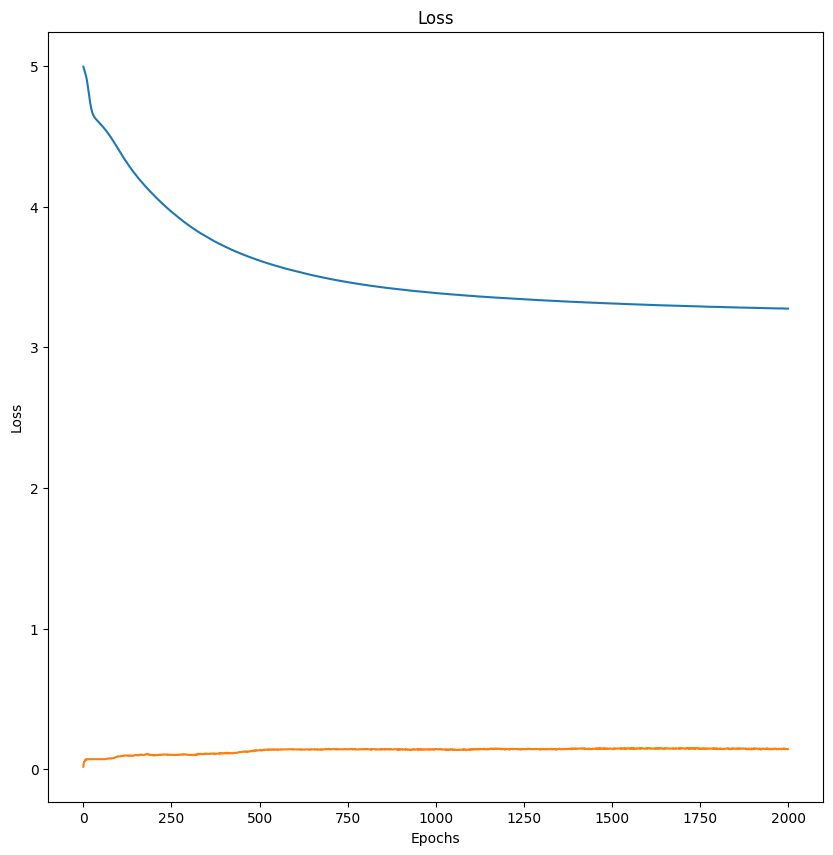

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(model1.history.history['loss'])
plt.plot(model1.history.history['accuracy'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [26]:
# The input layer

weights1 = model1.get_weights()[0]
print(weights1.shape)
# print(weights[1][1])
# print(weights)

# weights = model.get_weights()[2]
# print (weights)

(148, 2)


In [27]:
def create_embedding_word_dict(unique_word, unique_word_dict, weights):
    # get the weight for each unique word
    embedding_dict = {}
    for word in unique_word:  # to pick a row of weight of two values for each unique word since weights = 21*2
        embedding_dict.update({word: weights[unique_word_dict.get(word)]})
    return embedding_dict

In [28]:
embedding_dict1 = create_embedding_word_dict(unique_word1, unique_word_dict1, weights1)

In [29]:
embedding_dict1

{'according': array([-10.440557 ,   7.8144913], dtype=float32),
 'additional': array([0.4266445, 2.1276581], dtype=float32),
 'after': array([ 1.3136104, -3.9235117], dtype=float32),
 'algorithm': array([ 3.4771626, -4.239397 ], dtype=float32),
 'another': array([-3.367199,  7.457637], dtype=float32),
 'architecture': array([-0.2885732,  0.3604434], dtype=float32),
 'architectures': array([ 0.7504076, -0.6692141], dtype=float32),
 'assigned': array([-1.7350817 ,  0.19092989], dtype=float32),
 'associations': array([-0.5810466, -0.9798435], dtype=float32),
 'assumption': array([-0.8581888,  5.5823455], dtype=float32),
 'authors': array([-10.100971,   4.344747], dtype=float32),
 'bagofwords': array([-0.9189531,  3.417507 ], dtype=float32),
 'being': array([-1.4352217 , -0.16771396], dtype=float32),
 'better': array([-1.6049294,  2.5845451], dtype=float32),
 'between': array([ 5.490736 , -1.1620508], dtype=float32),
 'blank’': array([-3.6330419, -0.5521484], dtype=float32),
 'by': array([

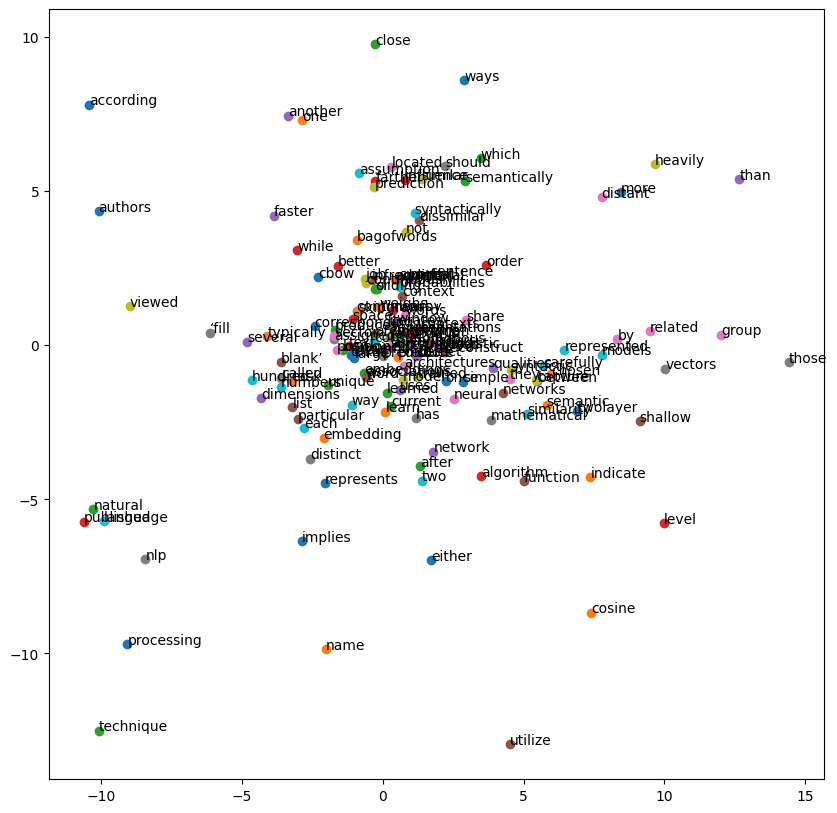

In [30]:
# from mpl_toolkits.mplot3d import Axes3D
# fig, axs = plt.subplots(len(embedding_dict.keys()), 3, figsize=(15, 10), subplot_kw={'projection': '3d'})
# print(len(embedding_dict.keys()))
# axs = axs.flatten()
# # Iterate through unique_word and plot in each subplot
# for i, word in enumerate(unique_word):
#     coord = embedding_dict.get(word)
#     ax = axs[i]

#     if coord is not None:
#         ax.scatter(coord[0], coord[1], coord[2], c='b', marker='o')
#ax.text(coord[0], coord[1], coord[2], s=word)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
#ax.set_title(word)

# Remove empty subplots
# for j in range(len(unique_word), len(axs)):
#     fig.delaxes(axs[j])

# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 10))
# i = 0
# ax_list = []
# for word in unique_word:
#     #print(i, ' >> ', word)
#     coord = embedding_dict.get(word)
#     fig = plt.figure()
#     ax = fig.add_subplot( projection='3d')
#     ax.scatter(coord[0], coord[1], coord[2], c='b', marker='o')
#     ax.text(coord[0], coord[1], coord[2], s=word)
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.legend()
#     ax_list.append(ax)

#     # plt.scatter(coord[0], coord[1])
#     # plt.annotate(word, (coord[0], coord[1]))
#     i = i + 1
#     plt.legend(unique_word)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(10, 10))
for word in unique_word1:
    coord = embedding_dict1.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))

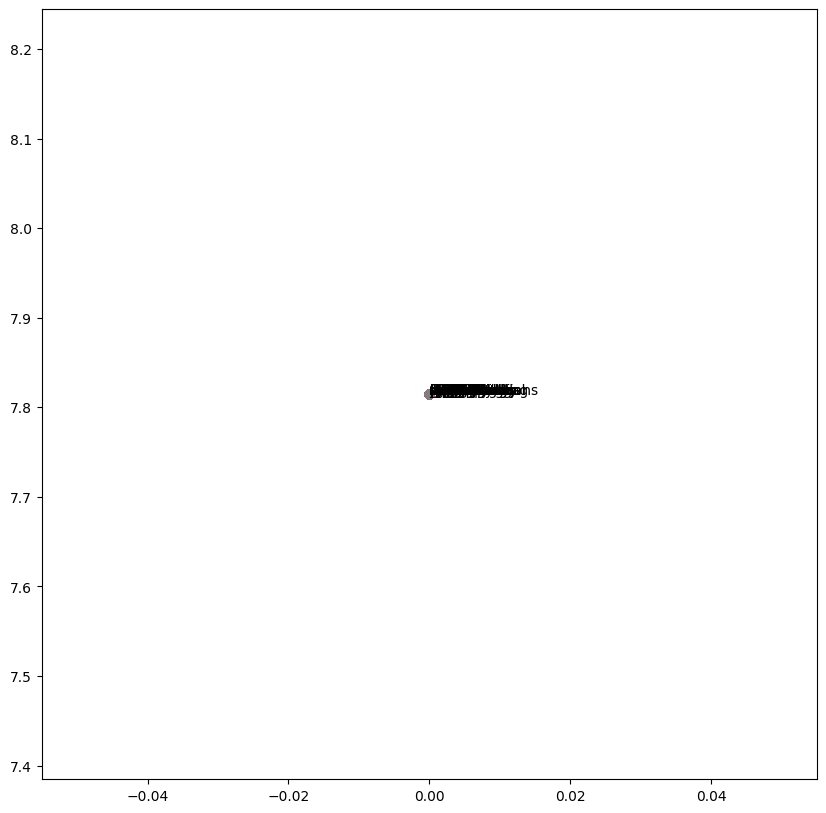

In [31]:
plt.figure(figsize=(10, 10))
i = 0
weights1 = model1.get_weights()[0]
for word in list(unique_word_dict1.keys()):
    coord = embedding_dict1.get(word)
    if weights1[i][0] < 0 < weights1[i][1]:
        plt.scatter(0, weights1[i][1])
        plt.annotate(word, (0, weights1[i][1]))
    else:
        plt.scatter(weights1[i][0], weights1[i][1])
        plt.annotate(word, (weights1[i][0], weights1[i][1]))

# texts2

In [32]:
texts2

['GloVe, coined from Global Vectors, is a model for distributed word representation',
 ' The model is an unsupervised learning algorithm for obtaining vector representations for words',
 ' This is achieved by mapping words into a meaningful space where the distance between words is related to semantic similarity',
 '[1] Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space',
 ' It is developed as an open-source project at Stanford[2] and was launched in 2014',
 ' As log-bilinear regression model for unsupervised learning of word representations, it combines the features of two model families, namely the global matrix factorization and local context window methods',
 '[3] GloVe can be used to find relations between words like synonyms, company-product relations, zip codes and cities, etc',
 ' However, the unsupervised learning algorithm is not effec

In [33]:
word_lists2, all_text2 = get_training_data(texts2)

['glove', 'coined', 'global', 'vectors', 'model', 'distributed', 'word', 'representation']
['model', 'an', 'unsupervised', 'learning', 'algorithm', 'obtaining', 'vector', 'representations', 'words']
['achieved', 'by', 'mapping', 'words', 'into', 'meaningful', 'space', 'distance', 'between', 'words', 'related', 'semantic', 'similarity']
['training', 'performed', 'aggregated', 'global', 'wordword', 'cooccurrence', 'statistics', 'corpus', 'resulting', 'representations', 'showcase', 'interesting', 'linear', 'substructures', 'word', 'vector', 'space']
['developed', 'an', 'opensource', 'project', 'at', 'launched']
['logbilinear', 'regression', 'model', 'unsupervised', 'learning', 'word', 'representations', 'combines', 'features', 'two', 'model', 'families', 'namely', 'global', 'matrix', 'factorization', 'local', 'context', 'window', 'methods']
['glove', 'used', 'find', 'relations', 'between', 'words', 'like', 'synonyms', 'companyproduct', 'relations', 'zip', 'codes', 'cities', 'etc']
['howev

In [34]:
word_lists2

[['glove', 'coined'],
 ['glove', 'global'],
 ['coined', 'global'],
 ['coined', 'glove'],
 ['coined', 'vectors'],
 ['global', 'vectors'],
 ['global', 'coined'],
 ['global', 'model'],
 ['global', 'glove'],
 ['vectors', 'model'],
 ['vectors', 'global'],
 ['vectors', 'distributed'],
 ['vectors', 'coined'],
 ['model', 'distributed'],
 ['model', 'vectors'],
 ['model', 'word'],
 ['model', 'global'],
 ['distributed', 'word'],
 ['distributed', 'model'],
 ['distributed', 'representation'],
 ['distributed', 'vectors'],
 ['word', 'representation'],
 ['word', 'distributed'],
 ['word', 'model'],
 ['representation', 'word'],
 ['representation', 'distributed'],
 ['model', 'an'],
 ['model', 'unsupervised'],
 ['an', 'unsupervised'],
 ['an', 'model'],
 ['an', 'learning'],
 ['unsupervised', 'learning'],
 ['unsupervised', 'an'],
 ['unsupervised', 'algorithm'],
 ['unsupervised', 'model'],
 ['learning', 'algorithm'],
 ['learning', 'unsupervised'],
 ['learning', 'obtaining'],
 ['learning', 'an'],
 ['algorithm

In [35]:
all_text2

['build',
 'spacy',
 'computing',
 'distance',
 'distress',
 'spelling',
 'interesting',
 'opensource',
 'an',
 'global',
 'synonyms',
 'related',
 'context',
 'algorithm',
 'similarity',
 'designed',
 'measures',
 'patient',
 'set',
 'glove',
 'word',
 'while',
 'learning',
 'list',
 'coined',
 'substructures',
 'effective',
 'library',
 'cooccurrence',
 'resulting',
 'project',
 'however',
 'mapping',
 'linear',
 'online',
 'matrix',
 'statistics',
 'systems',
 'achieved',
 'like',
 'interviews',
 'that',
 'meanings',
 'launched',
 'local',
 'unsupervised',
 'performed',
 'between',
 'offline',
 'detect',
 'approach',
 'by',
 'cosine',
 'vector',
 'etc',
 'representation',
 'zip',
 'relations',
 'wordword',
 'corpus',
 'representations',
 'model',
 'developed',
 'single',
 'structure',
 'find',
 'features',
 'vectors',
 'combines',
 'framework',
 'cities',
 'not',
 'used',
 'into',
 'identifying',
 'morphological',
 'factorization',
 'training',
 'showcase',
 'families',
 'window',
 

In [36]:
unique_word_dict2, number_of_unique_words2 = create_unique_word_dict(all_text2)

In [37]:
unique_word_dict2

{'achieved': 0,
 'aggregated': 1,
 'algorithm': 2,
 'an': 3,
 'approach': 4,
 'at': 5,
 'between': 6,
 'build': 7,
 'by': 8,
 'calculates': 9,
 'cities': 10,
 'codes': 11,
 'coined': 12,
 'combines': 13,
 'companyproduct': 14,
 'computing': 15,
 'context': 16,
 'cooccurrence': 17,
 'corpus': 18,
 'cosine': 19,
 'designed': 20,
 'detect': 21,
 'developed': 22,
 'different': 23,
 'distance': 24,
 'distress': 25,
 'distributed': 26,
 'effective': 27,
 'embedding': 28,
 'etc': 29,
 'euclidean': 30,
 'factorization': 31,
 'families': 32,
 'features': 33,
 'find': 34,
 'framework': 35,
 'global': 36,
 'glove': 37,
 'homographs': 38,
 'however': 39,
 'identifying': 40,
 'interesting': 41,
 'interviews': 42,
 'into': 43,
 'launched': 44,
 'learning': 45,
 'library': 46,
 'like': 47,
 'linear': 48,
 'list': 49,
 'local': 50,
 'logbilinear': 51,
 'mapping': 52,
 'match': 53,
 'matrix': 54,
 'meaningful': 55,
 'meanings': 56,
 'measures': 57,
 'methods': 58,
 'model': 59,
 'morphological': 60,
 '

In [38]:
number_of_unique_words2

106

In [39]:
unique_word2 = list(unique_word_dict2.keys())

In [40]:
unique_word2

['achieved',
 'aggregated',
 'algorithm',
 'an',
 'approach',
 'at',
 'between',
 'build',
 'by',
 'calculates',
 'cities',
 'codes',
 'coined',
 'combines',
 'companyproduct',
 'computing',
 'context',
 'cooccurrence',
 'corpus',
 'cosine',
 'designed',
 'detect',
 'developed',
 'different',
 'distance',
 'distress',
 'distributed',
 'effective',
 'embedding',
 'etc',
 'euclidean',
 'factorization',
 'families',
 'features',
 'find',
 'framework',
 'global',
 'glove',
 'homographs',
 'however',
 'identifying',
 'interesting',
 'interviews',
 'into',
 'launched',
 'learning',
 'library',
 'like',
 'linear',
 'list',
 'local',
 'logbilinear',
 'mapping',
 'match',
 'matrix',
 'meaningful',
 'meanings',
 'measures',
 'methods',
 'model',
 'morphological',
 'namely',
 'not',
 'obtaining',
 'offline',
 'online',
 'opensource',
 'patient',
 'performed',
 'project',
 'psychological',
 'regression',
 'related',
 'relations',
 'representation',
 'representations',
 'resulting',
 'same',
 'sema

In [41]:
matrix_x2, matrix_y2 = one_hot_representation(word_lists2, number_of_unique_words2, unique_word_dict2)

538it [00:00, 27202.58it/s]

['glove', 'coined']
glove 37
coined 12
['glove', 'global']
glove 37
global 36
['coined', 'global']
coined 12
global 36
['coined', 'glove']
coined 12
glove 37
['coined', 'vectors']
coined 12
vectors 99
['global', 'vectors']
global 36
vectors 99
['global', 'coined']
global 36
coined 12
['global', 'model']
global 36
model 59
['global', 'glove']
global 36
glove 37
['vectors', 'model']
vectors 99
model 59
['vectors', 'global']
vectors 99
global 36
['vectors', 'distributed']
vectors 99
distributed 26
['vectors', 'coined']
vectors 99
coined 12
['model', 'distributed']
model 59
distributed 26
['model', 'vectors']
model 59
vectors 99
['model', 'word']
model 59
word 102
['model', 'global']
model 59
global 36
['distributed', 'word']
distributed 26
word 102
['distributed', 'model']
distributed 26
model 59
['distributed', 'representation']
distributed 26
representation 74
['distributed', 'vectors']
distributed 26
vectors 99
['word', 'representation']
word 102
representation 74
['word', 'distributed

In [42]:
matrix_x2 = tf.convert_to_tensor(matrix_x2, dtype=tf.float32)
matrix_y2 = tf.convert_to_tensor(matrix_y2, dtype=tf.float32)
print(matrix_x2.shape)
print(matrix_y2.shape)

(538, 106)
(538, 106)


In [43]:
model2 = CreateModel(matrix_x2.shape[1], matrix_y2.shape[1])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 106)]             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 214       
                                                                 
 dense_3 (Dense)             (None, 106)               318       
                                                                 
Total params: 532 (2.08 KB)
Trainable params: 532 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
model2.fit(
    x=matrix_x2,
    y=matrix_y2,
    epochs=2000
)

Epoch 1/2000
17/17 [==============================] - 1s 2ms/step - loss: 4.6639 - accuracy: 0.0149
Epoch 2/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6595 - accuracy: 0.0167
Epoch 3/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6556 - accuracy: 0.0186
Epoch 4/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6520 - accuracy: 0.0242
Epoch 5/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6485 - accuracy: 0.0316
Epoch 6/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6447 - accuracy: 0.0372
Epoch 7/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6412 - accuracy: 0.0409
Epoch 8/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6377 - accuracy: 0.0446
Epoch 9/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6340 - accuracy: 0.0446
Epoch 10/2000
17/17 [==============================] - 0s 2ms/step - loss: 4.6302 - accuracy: 0.0483

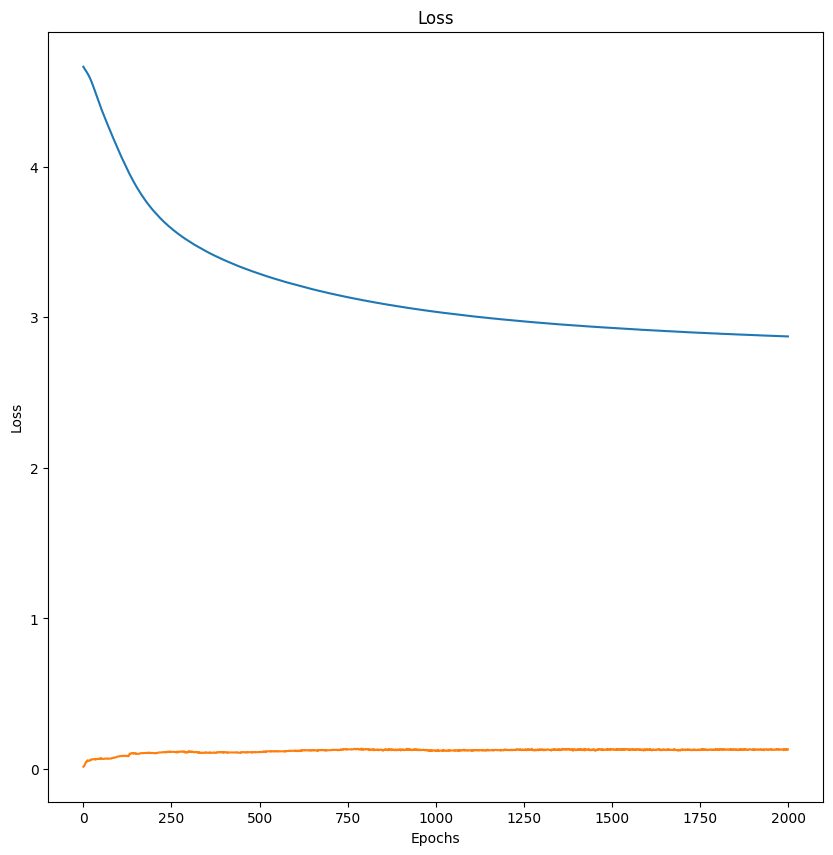

In [45]:
plt.figure(figsize=(10, 10))
plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['accuracy'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [46]:
weights2 = model2.get_weights()[0]

In [47]:
weights2.shape

(106, 2)

In [48]:
embedding_dict2 = create_embedding_word_dict(unique_word2, unique_word_dict2, weights2)

In [49]:
embedding_dict2

{'achieved': array([-0.7158328, -1.2910916], dtype=float32),
 'aggregated': array([5.357776, 5.652098], dtype=float32),
 'algorithm': array([ 1.4875634, -0.6119288], dtype=float32),
 'an': array([5.90857   , 0.61148113], dtype=float32),
 'approach': array([-3.2941325, -8.517672 ], dtype=float32),
 'at': array([10.372041 ,  3.6438413], dtype=float32),
 'between': array([-3.4601111, -2.523033 ], dtype=float32),
 'build': array([ 0.25412998, -4.9689918 ], dtype=float32),
 'by': array([-0.27695283, -1.347845  ], dtype=float32),
 'calculates': array([ 1.427611  , -0.14881827], dtype=float32),
 'cities': array([-11.901557 ,   0.7961485], dtype=float32),
 'codes': array([-9.596726 , -0.1900403], dtype=float32),
 'coined': array([0.6686486, 1.3767635], dtype=float32),
 'combines': array([ 2.2030313, -2.1503892], dtype=float32),
 'companyproduct': array([-8.167611 , -2.4481354], dtype=float32),
 'computing': array([ 0.08658992, -2.159233  ], dtype=float32),
 'context': array([0.49103636, 9.1740

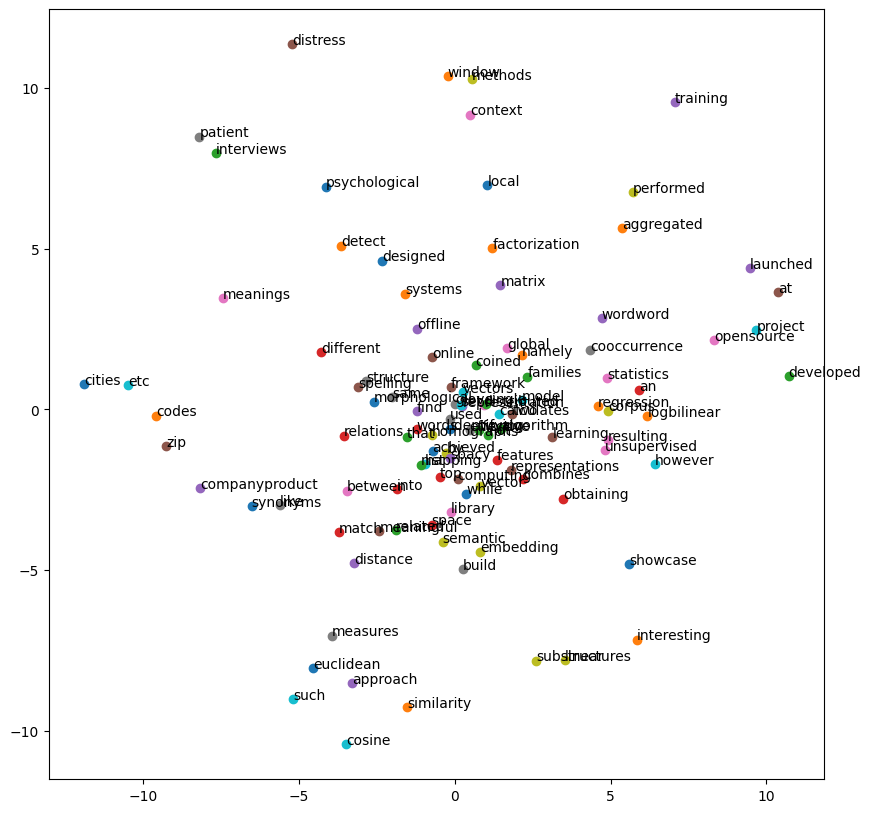

In [50]:
plt.figure(figsize=(10, 10))
for word in unique_word2:
    coord = embedding_dict2.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))

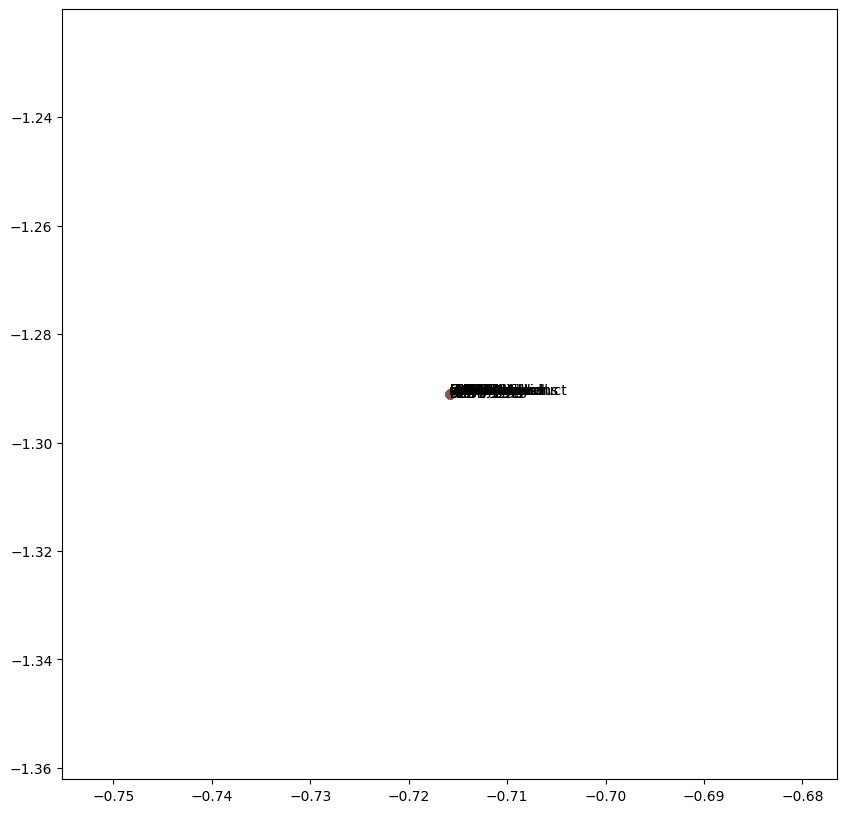

In [51]:
plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict2.keys()):
    coord = embedding_dict2.get(word)
    if weights2[i][0] < 0 < weights2[i][1]:
        plt.scatter(0, weights2[i][1])
        plt.annotate(word, (0, weights2[i][1]))
    else:
        plt.scatter(weights2[i][0], weights2[i][1])
        plt.annotate(word, (weights2[i][0], weights2[i][1]))

In [52]:
embedding1 = list(embedding_dict1.values())
embedding2 = list(embedding_dict2.values())

In [53]:
cosineSimilarity = cosine_similarity(embedding1, embedding2)

In [54]:
cosineSimilarity

array([[-0.13585702, -0.11588691, -0.96835065, ...,  0.44357407,
        -0.37734944,  0.7220452 ],
       [-0.95283645,  0.846844  , -0.19118105, ..., -0.618308  ,
         0.6737252 , -0.31401289],
       [ 0.6753774 , -0.46978754,  0.6543615 , ...,  0.14510122,
        -0.21653658, -0.20019403],
       ...,
       [ 0.99959356, -0.97503525, -0.1439894 , ...,  0.8433272 ,
        -0.8801106 ,  0.6101689 ],
       [-0.98733133,  0.99567103,  0.27186173, ..., -0.9062301 ,
         0.93452805, -0.70831555],
       [ 0.42513287, -0.6377202 , -0.94824713, ...,  0.85984683,
        -0.8205197 ,  0.98225725]], dtype=float32)

<Axes: >

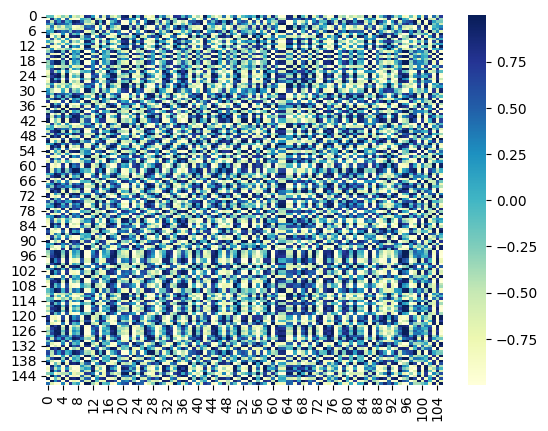

In [55]:
sns.heatmap(cosineSimilarity, cmap="YlGnBu")

In [56]:
euclideanDistances = euclidean_distances(embedding1, embedding2)

In [57]:
euclideanDistances

array([[13.322233  , 15.945635  , 14.604267  , ..., 12.492117  ,
        15.951026  ,  9.022724  ],
       [ 3.604595  ,  6.0611663 ,  2.937837  , ...,  3.2078133 ,
         4.343969  , 10.23855   ],
       [ 3.3238947 , 10.394594  ,  3.3161485 , ...,  4.1664534 ,
         7.5639777 , 10.953764  ],
       ...,
       [ 0.28670382,  8.95415   ,  2.1355295 , ...,  0.73970455,
         6.57269   ,  8.671934  ],
       [ 2.7329128 ,  6.5291734 ,  1.7554704 , ...,  2.5779006 ,
         4.3401003 , 10.282806  ],
       [ 5.681324  , 12.631429  ,  7.691802  , ...,  5.0165305 ,
        11.115443  ,  3.5025713 ]], dtype=float32)

<Axes: >

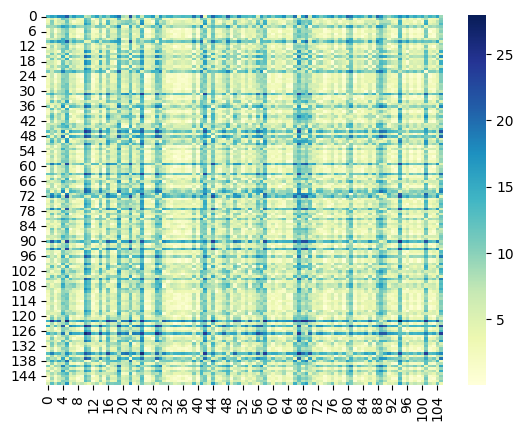

In [58]:
sns.heatmap(euclideanDistances, cmap="YlGnBu")

In [59]:
from sklearn.manifold import MDS

In [60]:
embedding1 = np.array(embedding1)
embedding2 = np.array(embedding2)
embedding = np.concatenate((embedding1, embedding2), axis=0)
embedding_s = np.cov(embedding)
embedding_s.shape

(254, 254)

In [61]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(embedding_s)

xs, ys = pos[:, 0], pos[:, 1]

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


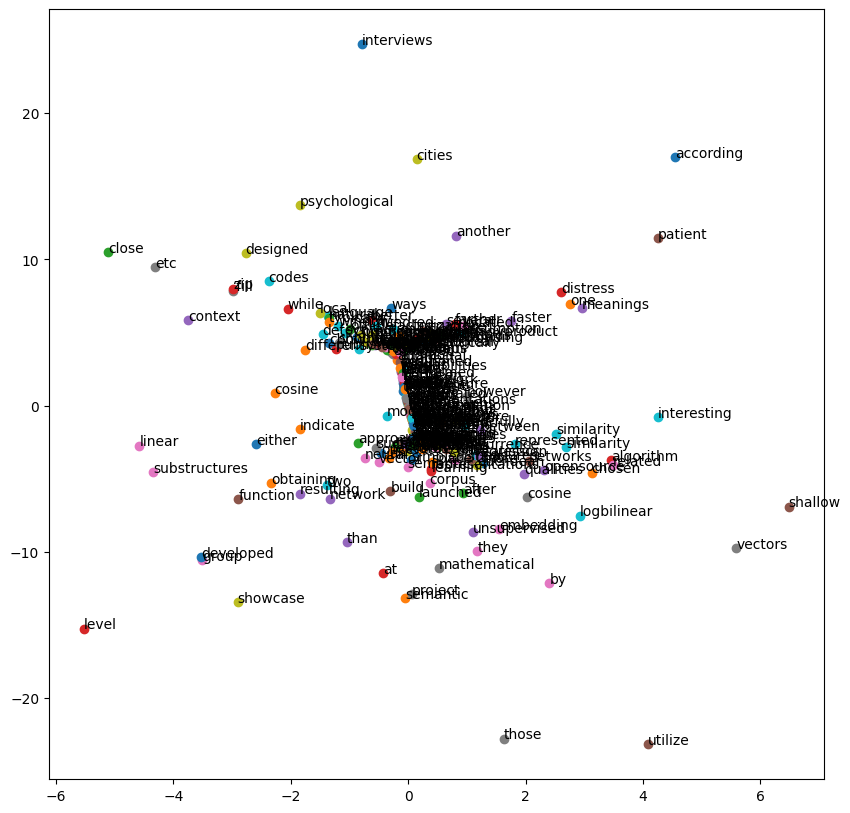

In [62]:
plt.figure(figsize=(10, 10))
for x, y, name in zip(xs, ys, list(unique_word_dict1.keys()) + list(unique_word_dict2.keys())):
    plt.scatter(x, y)
    plt.annotate(name, (x, y))
    
plt.show()